<a href="https://colab.research.google.com/github/mahim83/Data_Generation_using_Modelling_and_Simulation_for_Machine_Learning/blob/main/Topsis_for_pretrained_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load STS Benchmark TEST split from Hugging Face
df = pd.read_json(
    "hf://datasets/mteb/stsbenchmark-sts/test.jsonl.gz",
    lines=True
)

# Keep only required columns
df = df[['sentence1', 'sentence2', 'score']].copy()

# Normalize similarity score from 0–5 to 0–1
df['score_norm'] = df['score'] / 5.0

# Optional: sample for faster execution in Colab
df = df.sample(500, random_state=42).reset_index(drop=True)

# Preview data
df.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,sentence1,sentence2,score,score_norm
0,A group of people are sitting at at a beach on...,A group of people are sitting at a beach watch...,4.20,0.84
1,Governor Gray Davis estimated yesterday that t...,State officials estimated the cost at nearly $...,3.50,0.70
2,You need to read a lot to know what you like a...,You have to decide how much you want to demand...,0.00,0.00
3,Three children wrestle on a floral carpet.,Three children playing on the floor.,3.80,0.76
4,Q: Can I buy coverage for prescription drugs r...,Congress has added a new benefit - an option t...,1.25,0.25


In [2]:
import torch
import transformers
import pandas as pd
import numpy as np
import time
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer

# Define a list of pre-trained model names
model_names = [
    'sentence-transformers/all-MiniLM-L6-v2',
    'sentence-transformers/paraphrase-MiniLM-L12-v2',
    'sentence-transformers/all-mpnet-base-v2',
    'distilbert-base-uncased',
    'roberta-base'
]

# Determine the computing device (GPU/CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Define a helper function to calculate model size in MB
def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

# Initialize lists to store loaded models, tokenizers, and their sizes
loaded_models = []
loaded_tokenizers = []
model_sizes_mb = []

# Iterate through each model name, load the model and tokenizer, and get its size
print("Loading models and tokenizers...")
for model_name in model_names:
    print(f"  Loading {model_name}...")
    if model_name.startswith('sentence-transformers/'):
        # SentenceTransformer handles model and tokenizer together
        model = SentenceTransformer(model_name)
        tokenizer = None # Tokenizer is integrated into SentenceTransformer
    else:
        # Load AutoModel and AutoTokenizer separately
        model = AutoModel.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Move model to the determined device
    model.to(device)

    # Calculate model size
    size_mb = get_model_size_mb(model)

    loaded_models.append(model)
    loaded_tokenizers.append(tokenizer)
    model_sizes_mb.append(size_mb)
    print(f"    Model size: {size_mb:.2f} MB")

print("All models and tokenizers loaded successfully.")

# Display summary of loaded models
for i, model_name in enumerate(model_names):
    print(f"\nModel: {model_name}")
    print(f"  Size: {model_sizes_mb[i]:.2f} MB")
    print(f"  Tokenizer loaded: {loaded_tokenizers[i] is not None}")

Using device: cpu
Loading models and tokenizers...
  Loading sentence-transformers/all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

    Model size: 86.65 MB
  Loading sentence-transformers/paraphrase-MiniLM-L12-v2...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

    Model size: 127.27 MB
  Loading sentence-transformers/all-mpnet-base-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

    Model size: 417.66 MB
  Loading distilbert-base-uncased...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

    Model size: 253.16 MB
  Loading roberta-base...


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

    Model size: 475.49 MB
All models and tokenizers loaded successfully.

Model: sentence-transformers/all-MiniLM-L6-v2
  Size: 86.65 MB
  Tokenizer loaded: False

Model: sentence-transformers/paraphrase-MiniLM-L12-v2
  Size: 127.27 MB
  Tokenizer loaded: False

Model: sentence-transformers/all-mpnet-base-v2
  Size: 417.66 MB
  Tokenizer loaded: False

Model: distilbert-base-uncased
  Size: 253.16 MB
  Tokenizer loaded: True

Model: roberta-base
  Size: 475.49 MB
  Tokenizer loaded: True


In [3]:
from sklearn.metrics.pairwise import cosine_similarity

# Initialize lists to store results
all_pearson_correlations = []
all_inference_times = []

# Function to get embeddings
def get_embeddings(model, tokenizer, sentences, device, is_sbert=False):
    start_time = time.time()
    if is_sbert:
        # SentenceTransformer models have their own encode method
        embeddings = model.encode(sentences, convert_to_tensor=True, device=device)
    else:
        # For AutoModel, manually tokenize and get embeddings
        sentences = [str(s) for s in sentences if pd.notna(s)]
        inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            # Take the mean of the last hidden state for sentence embedding
            embeddings = outputs.last_hidden_state.mean(dim=1)
    end_time = time.time()
    inference_time_per_sample = (end_time - start_time) / len(sentences)
    return embeddings, inference_time_per_sample

print("Generating embeddings and computing metrics...")
for i, model_name in enumerate(model_names):
    model = loaded_models[i]
    tokenizer = loaded_tokenizers[i]
    is_sbert = model_name.startswith('sentence-transformers/')

    print(f"\nProcessing model: {model_name}")

    # Get embeddings for sentence1 and sentence2
    embeddings1, time1 = get_embeddings(model, tokenizer, df['sentence1'].tolist(), device, is_sbert)
    embeddings2, time2 = get_embeddings(model, tokenizer, df['sentence2'].tolist(), device, is_sbert)

    # Calculate average inference time per sample for this model
    avg_inference_time = (time1 + time2) / 2
    all_inference_times.append(avg_inference_time)
    print(f"  Average Inference Time per sample: {avg_inference_time:.6f} seconds")

    # Compute cosine similarity between sentence1 and sentence2 embeddings
    # Convert embeddings to numpy for sklearn cosine_similarity if they are torch tensors
    if isinstance(embeddings1, torch.Tensor):
        embeddings1_np = embeddings1.cpu().numpy()
    else:
        embeddings1_np = embeddings1

    if isinstance(embeddings2, torch.Tensor):
        embeddings2_np = embeddings2.cpu().numpy()
    else:
        embeddings2_np = embeddings2

    # Ensure embeddings have compatible dimensions for cosine_similarity
    if embeddings1_np.ndim == 1: embeddings1_np = embeddings1_np.reshape(1, -1)
    if embeddings2_np.ndim == 1: embeddings2_np = embeddings2_np.reshape(1, -1)

    # Cosine similarity expects 2D arrays, each row is a sample

    if not is_sbert:
        embeddings1_np = embeddings1_np / np.linalg.norm(embeddings1_np, axis=1, keepdims=True)
        embeddings2_np = embeddings2_np / np.linalg.norm(embeddings2_np, axis=1, keepdims=True)

    # Compute cosine similarity for each pair
    cosine_scores = np.array([np.dot(vec1, vec2) for vec1, vec2 in zip(embeddings1_np, embeddings2_np)])

    # Calculate Pearson correlation coefficient
    pearson_corr, _ = scipy.stats.pearsonr(df['score_norm'], cosine_scores)
    all_pearson_correlations.append(pearson_corr)
    print(f"  Pearson Correlation: {pearson_corr:.4f}")

print("Embedding generation and metric computation complete.")

Generating embeddings and computing metrics...

Processing model: sentence-transformers/all-MiniLM-L6-v2
  Average Inference Time per sample: 0.009880 seconds
  Pearson Correlation: 0.8330

Processing model: sentence-transformers/paraphrase-MiniLM-L12-v2
  Average Inference Time per sample: 0.012577 seconds
  Pearson Correlation: 0.7416

Processing model: sentence-transformers/all-mpnet-base-v2
  Average Inference Time per sample: 0.047832 seconds
  Pearson Correlation: 0.8350

Processing model: distilbert-base-uncased
  Average Inference Time per sample: 0.055008 seconds
  Pearson Correlation: 0.6231

Processing model: roberta-base
  Average Inference Time per sample: 0.108592 seconds
  Pearson Correlation: 0.1401
Embedding generation and metric computation complete.


In [4]:
model_metrics_df = pd.DataFrame({
    'Model Name': model_names,
    'Pearson Correlation': all_pearson_correlations,
    'Inference Time (s/sample)': all_inference_times,
    'Model Size (MB)': model_sizes_mb
})


# Inference Time: lower is better for Computational Cost. Let's make 1 the worst (highest time), 5 the best (lowest time).
min_inference_time = model_metrics_df['Inference Time (s/sample)'].min()
max_inference_time = model_metrics_df['Inference Time (s/sample)'].max()

model_metrics_df['Computational Cost'] = model_metrics_df['Inference Time (s/sample)'].apply(lambda x:
    5 - ((x - min_inference_time) / (max_inference_time - min_inference_time) * 4))
model_metrics_df['Computational Cost'] = model_metrics_df['Computational Cost'].clip(1, 5).round(2)

# Model Size: lower is better for Deployment Ease. Let's make 1 the worst (largest size), 5 the best (smallest size).
min_model_size = model_metrics_df['Model Size (MB)'].min()
max_model_size = model_metrics_df['Model Size (MB)'].max()

model_metrics_df['Deployment Ease'] = model_metrics_df['Model Size (MB)'].apply(lambda x:
    5 - ((x - min_model_size) / (max_model_size - min_model_size) * 4))
model_metrics_df['Deployment Ease'] = model_metrics_df['Deployment Ease'].clip(1, 5).round(2)

print("Model Evaluation Metrics:")
print(model_metrics_df)

# Save the DataFrame to a CSV file
model_metrics_df.to_csv("model_evaluation_metrics.csv", index=False)
print("Model evaluation metrics saved to model_evaluation_metrics.csv")

Model Evaluation Metrics:
                                       Model Name  Pearson Correlation  \
0          sentence-transformers/all-MiniLM-L6-v2             0.832984   
1  sentence-transformers/paraphrase-MiniLM-L12-v2             0.741636   
2         sentence-transformers/all-mpnet-base-v2             0.834977   
3                         distilbert-base-uncased             0.623124   
4                                    roberta-base             0.140141   

   Inference Time (s/sample)  Model Size (MB)  Computational Cost  \
0                   0.009880        86.651855                5.00   
1                   0.012577       127.266113                4.89   
2                   0.047832       417.661636                3.46   
3                   0.055008       253.158203                3.17   
4                   0.108592       475.493195                1.00   

   Deployment Ease  
0             5.00  
1             4.58  
2             1.59  
3             3.29  
4        

In [5]:
import numpy as np


criteria_types = np.array([1, -1, -1, 1, 1])
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) # Equal weights for 5 criteria

# Select the decision matrix columns for TOPSIS
decision_matrix = model_metrics_df[[
    'Pearson Correlation',
    'Inference Time (s/sample)',
    'Model Size (MB)',
    'Computational Cost',
    'Deployment Ease'
]].values

# Step 1: Normalize the decision matrix (Vector Normalization)
# nij = xij / sqrt(sum(xij^2 for all i))
normalized_matrix = decision_matrix / np.sqrt(np.sum(decision_matrix**2, axis=0))

# Step 2: Weighted Normalized Decision Matrix
# vij = wij * nij
weighted_normalized_matrix = normalized_matrix * weights

# Step 3: Determine Ideal (A_plus) and Negative-Ideal (A_minus) Solutions
A_plus = np.zeros(weighted_normalized_matrix.shape[1])
A_minus = np.zeros(weighted_normalized_matrix.shape[1])

for j in range(weighted_normalized_matrix.shape[1]):
    if criteria_types[j] == 1: # Benefit criterion: Ideal is max, Negative-ideal is min
        A_plus[j] = np.max(weighted_normalized_matrix[:, j])
        A_minus[j] = np.min(weighted_normalized_matrix[:, j])
    else: # Cost criterion: Ideal is min, Negative-ideal is max
        A_plus[j] = np.min(weighted_normalized_matrix[:, j])
        A_minus[j] = np.max(weighted_normalized_matrix[:, j])

# Step 4: Calculate Separation Measures
S_plus = np.sqrt(np.sum((weighted_normalized_matrix - A_plus)**2, axis=1))
S_minus = np.sqrt(np.sum((weighted_normalized_matrix - A_minus)**2, axis=1))

# Step 5: Calculate Relative Closeness to the Ideal Solution (TOPSIS Score)
# Ci = Si- / (Si+ + Si-)
topsis_score = S_minus / (S_plus + S_minus)

# Add TOPSIS score to the DataFrame
model_metrics_df['TOPSIS Score'] = topsis_score

# Step 6: Rank Alternatives
model_metrics_df['Rank'] = model_metrics_df['TOPSIS Score'].rank(ascending=False).astype(int)

# Create a new DataFrame for TOPSIS ranking, sorted by Rank
topsis_ranking_df = model_metrics_df[['Model Name', 'TOPSIS Score', 'Rank']].sort_values(by='Rank')

print("\nTOPSIS Model Ranking:")
print(topsis_ranking_df)

# Save the ranking to a CSV file
topsis_ranking_df.to_csv("topsis_model_ranking.csv", index=False)
print("\nTOPSIS model ranking saved to topsis_model_ranking.csv")


TOPSIS Model Ranking:
                                       Model Name  TOPSIS Score  Rank
0          sentence-transformers/all-MiniLM-L6-v2      0.998961     1
1  sentence-transformers/paraphrase-MiniLM-L12-v2      0.918778     2
3                         distilbert-base-uncased      0.572836     3
2         sentence-transformers/all-mpnet-base-v2      0.495674     4
4                                    roberta-base      0.000000     5

TOPSIS model ranking saved to topsis_model_ranking.csv


/tmp/ipython-input-2311974683.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=sorted_df, palette='viridis')


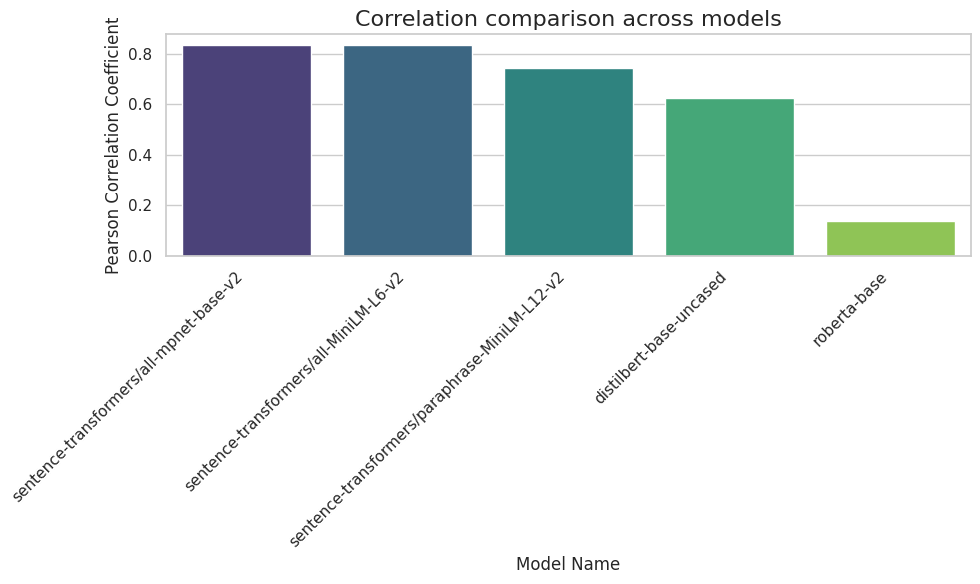

Chart saved to correlation_comparison.png


/tmp/ipython-input-2311974683.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=sorted_df, palette='viridis')


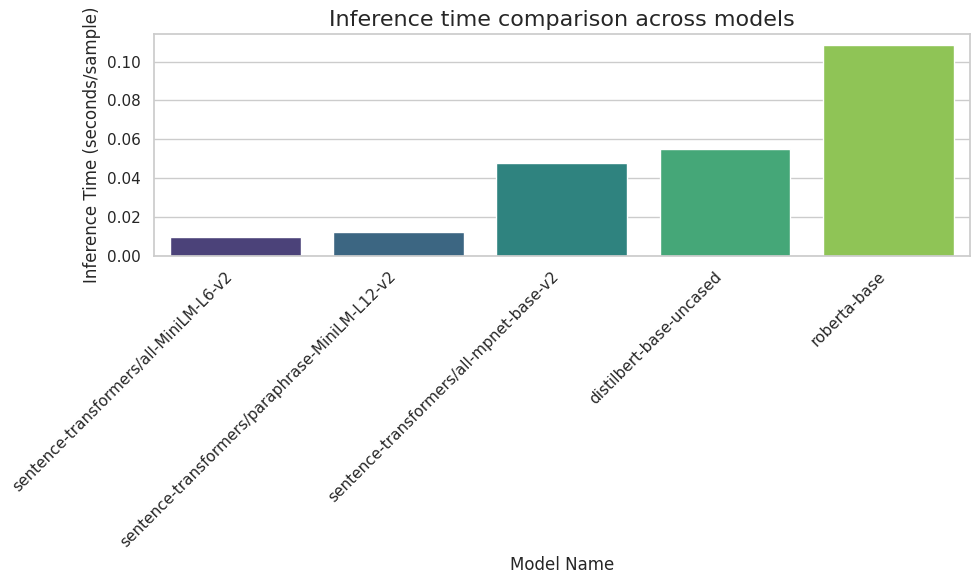

Chart saved to inference_time_comparison.png


/tmp/ipython-input-2311974683.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=sorted_df, palette='viridis')


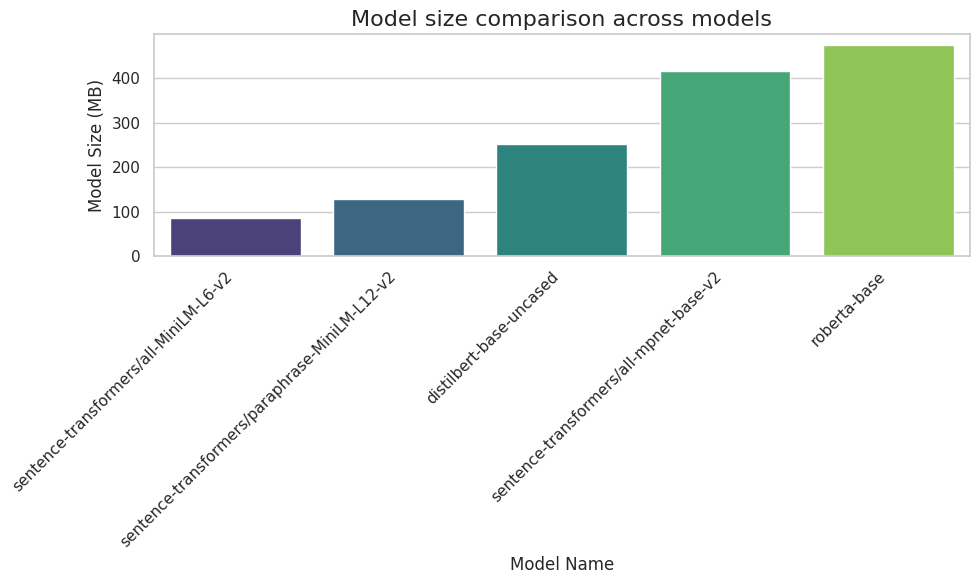

Chart saved to model_size_comparison.png


/tmp/ipython-input-2311974683.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=sorted_df, palette='viridis')


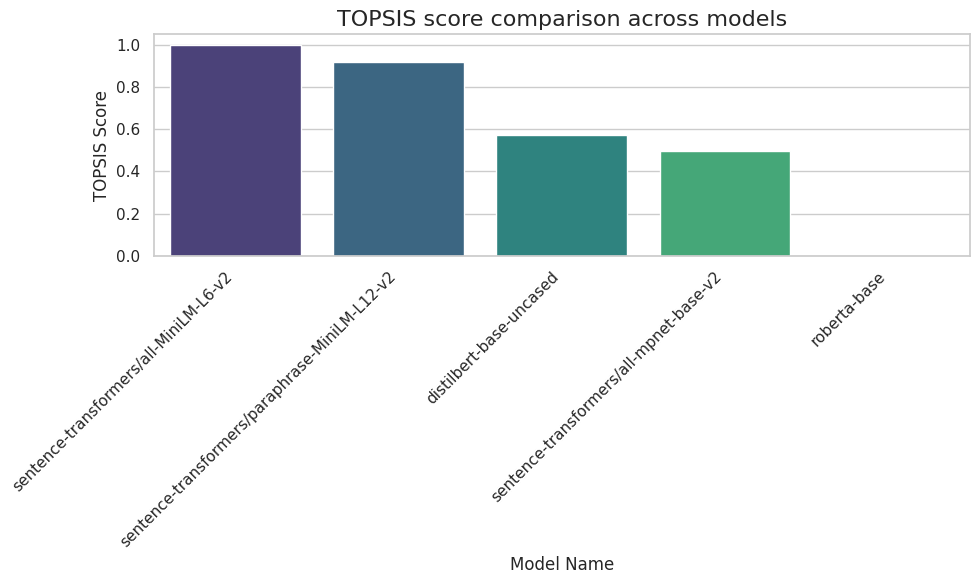

Chart saved to topsis_score_comparison.png


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style for plots
sns.set_theme(style="whitegrid")

def create_and_save_bar_chart(df, x_col, y_col, title, ylabel, filename, ascending=True):
    plt.figure(figsize=(10, 6))
    # Sort data for better visualization if needed
    sorted_df = df.sort_values(by=y_col, ascending=ascending)
    sns.barplot(x=x_col, y=y_col, data=sorted_df, palette='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Model Name', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Chart saved to {filename}")

# 1. Correlation comparison across models (Higher is better, so ascending=False for sorting)
create_and_save_bar_chart(model_metrics_df,
                          x_col='Model Name',
                          y_col='Pearson Correlation',
                          title='Correlation comparison across models',
                          ylabel='Pearson Correlation Coefficient',
                          filename='correlation_comparison.png',
                          ascending=False)

# 2. Inference time comparison across models (Lower is better, so ascending=True for sorting)
create_and_save_bar_chart(model_metrics_df,
                          x_col='Model Name',
                          y_col='Inference Time (s/sample)',
                          title='Inference time comparison across models',
                          ylabel='Inference Time (seconds/sample)',
                          filename='inference_time_comparison.png',
                          ascending=True)

# 3. Model size comparison across models (Lower is better, so ascending=True for sorting)
create_and_save_bar_chart(model_metrics_df,
                          x_col='Model Name',
                          y_col='Model Size (MB)',
                          title='Model size comparison across models',
                          ylabel='Model Size (MB)',
                          filename='model_size_comparison.png',
                          ascending=True)

# 4. TOPSIS score comparison across models (Higher is better, so ascending=False for sorting)
create_and_save_bar_chart(model_metrics_df,
                          x_col='Model Name',
                          y_col='TOPSIS Score',
                          title='TOPSIS score comparison across models',
                          ylabel='TOPSIS Score',
                          filename='topsis_score_comparison.png',
                          ascending=False)


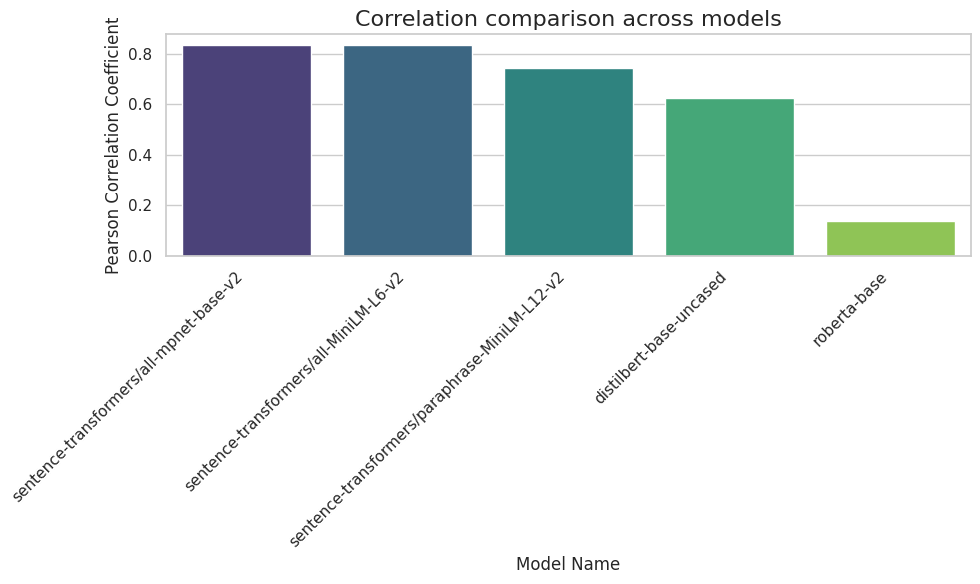

Chart saved to correlation_comparison.png


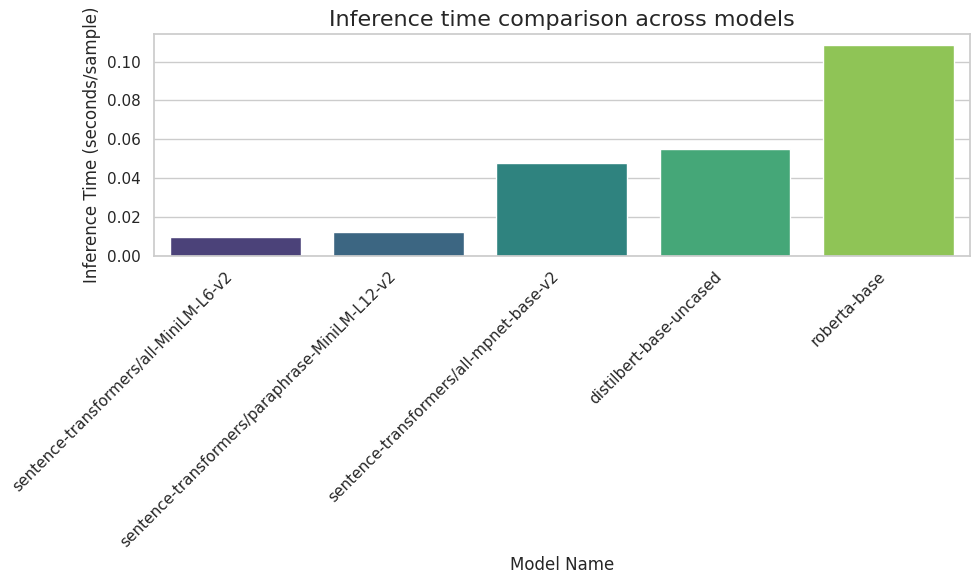

Chart saved to inference_time_comparison.png


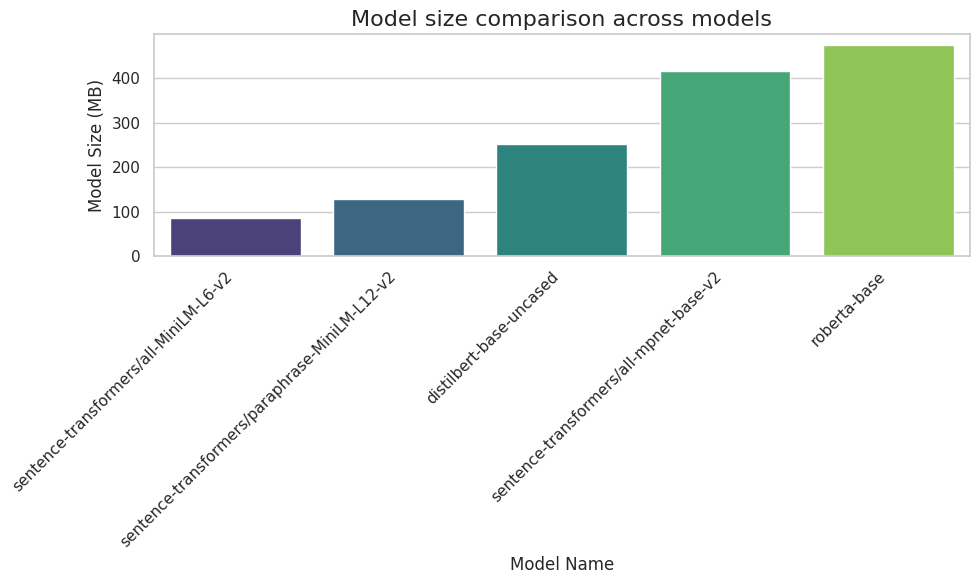

Chart saved to model_size_comparison.png


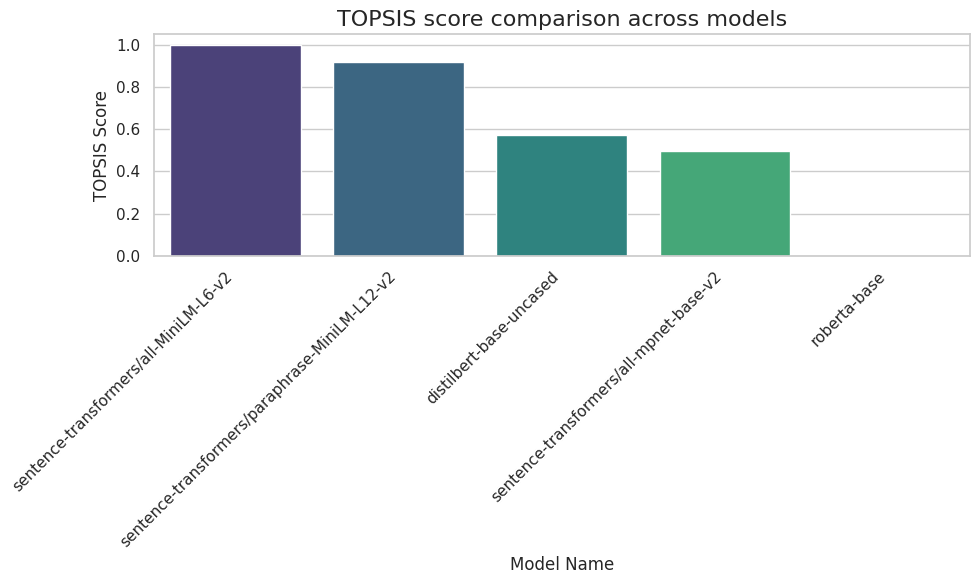

Chart saved to topsis_score_comparison.png


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style for plots
sns.set_theme(style="whitegrid")

def create_and_save_bar_chart(df, x_col, y_col, title, ylabel, filename, ascending=True):
    plt.figure(figsize=(10, 6))
    # Sort data for better visualization if needed
    sorted_df = df.sort_values(by=y_col, ascending=ascending)
    # Modified to suppress FutureWarning: Pass x_col to hue and set legend=False
    sns.barplot(x=x_col, y=y_col, data=sorted_df, palette='viridis', hue=x_col, legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Model Name', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    print(f"Chart saved to {filename}")

# 1. Correlation comparison across models (Higher is better, so ascending=False for sorting)
create_and_save_bar_chart(model_metrics_df,
                          x_col='Model Name',
                          y_col='Pearson Correlation',
                          title='Correlation comparison across models',
                          ylabel='Pearson Correlation Coefficient',
                          filename='correlation_comparison.png',
                          ascending=False)

# 2. Inference time comparison across models (Lower is better, so ascending=True for sorting)
create_and_save_bar_chart(model_metrics_df,
                          x_col='Model Name',
                          y_col='Inference Time (s/sample)',
                          title='Inference time comparison across models',
                          ylabel='Inference Time (seconds/sample)',
                          filename='inference_time_comparison.png',
                          ascending=True)

# 3. Model size comparison across models (Lower is better, so ascending=True for sorting)
create_and_save_bar_chart(model_metrics_df,
                          x_col='Model Name',
                          y_col='Model Size (MB)',
                          title='Model size comparison across models',
                          ylabel='Model Size (MB)',
                          filename='model_size_comparison.png',
                          ascending=True)

# 4. TOPSIS score comparison across models (Higher is better, so ascending=False for sorting)
create_and_save_bar_chart(model_metrics_df,
                          x_col='Model Name',
                          y_col='TOPSIS Score',
                          title='TOPSIS score comparison across models',
                          ylabel='TOPSIS Score',
                          filename='topsis_score_comparison.png',
                          ascending=False)
